In [1]:
#load required libraries:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras import optimizers
import tensorflow as tf
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint
# Load the data
file_path = 'strength_train.dat'  # Adjust this path to your file location
df = pd.read_csv(file_path, sep='\s+', header=None, names=['Deformation', 'Temperature', 'Strength'])
train_set_temp = []
train_set_strength = []
print(len(df))
middle_temperature = df['Temperature'].median()
closest_to_middle_index = (df['Temperature'] - middle_temperature).abs().idxmin()
first_data = df.iloc[closest_to_middle_index]
first_data_temperature = first_data['Temperature']
first_data_strength = first_data['Strength']
train_set_temp.append(first_data_temperature)
train_set_strength.append(first_data_strength)
df = df.drop(closest_to_middle_index).reset_index(drop=True)
print(len(df))
print(train_set_temp)
print(train_set_strength)
temperature_difference = (df['Temperature'] - first_data['Temperature']).abs()
furthest_index = temperature_difference.idxmax()
second_data = df.iloc[furthest_index]
second_data_temperature = second_data['Temperature']
second_data_strength = second_data['Strength']
train_set_temp.append(second_data_temperature)
train_set_strength.append(second_data_strength)
df = df.drop(furthest_index).reset_index(drop=True)
print(len(df))
print(train_set_temp)
print(train_set_strength)

1500
1499
[1546.0]
[3.4178994028614254]
1498
[1546.0, 52.0]
[3.4178994028614254, 5.013452281004516]


In [2]:
for i in range (3):
    max_dis = 0
    for j in range (len(df)):
        temp_c = df['Temperature'].values[j]
        min_dis=float('inf')
        for k in range (len(train_set_temp)):
            temp_low = train_set_temp[k]
            dis_low = abs(temp_c - temp_low)
            if dis_low < min_dis:
                min_dis = dis_low
        if min_dis > max_dis:
            max_dis = min_dis
            index_c = j
    itera_data = df.iloc[index_c]
    itera_data_temperature = itera_data['Temperature']
    itera_data_strength = itera_data['Strength']
    train_set_temp.append(itera_data_temperature)
    train_set_strength.append(itera_data_strength)
    df = df.drop(index_c).reset_index(drop=True)

print(train_set_temp)
print(train_set_strength)

[1546.0, 52.0, 3000.0, 803.0, 2273.0]
[3.4178994028614254, 5.013452281004516, 3.0779447566624487, 4.128029682385688, 2.96043827913771]


Text(0, 0.5, 'y')

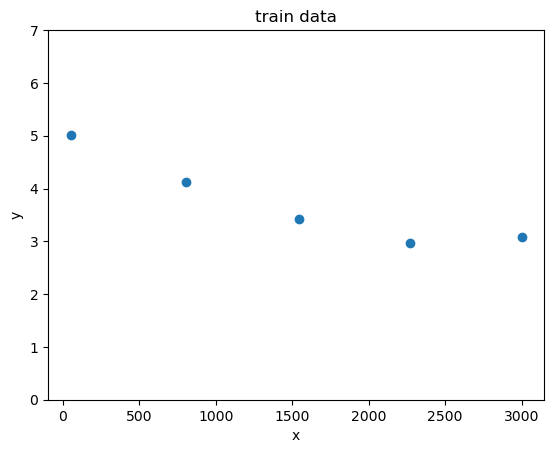

In [3]:
x = np.array(train_set_temp).reshape(-1,1)
y = np.array(train_set_strength)
poly_degree = 5
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
scaler = StandardScaler()

x_trans = poly_features.fit_transform(x)
x_trans = scaler.fit_transform(x_trans)

plt.scatter(x,y,marker='o')
plt.title("train data")
plt.ylim(0, 7)
plt.xlabel("x")
plt.ylabel("y")


In [4]:
import math
def my_NLL_loss(y_true,y_pred):
  mu=tf.slice(y_pred,[0,0],[-1,1])              # NN first output for μ     
  sigma=tf.math.exp(tf.slice(y_pred,[0,1],[-1,1]))   # NN second output for log(σ) 
  
  a=1/(tf.sqrt(2.*math.pi)*sigma) 
  b1=tf.square(mu-y_true)
  b2=2*tf.square(sigma)
  b=b1/b2
  
  loss = tf.reduce_sum(-tf.math.log(a)+b,axis=0)
  return loss
num_set = []
mean_kl_divergence_set = []
metric_set = []
for i in range (5,6):
    checkpoint_filepath = 'best_model_kl1.hdf5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)
    num_train = i
    x_fit = x_trans[:num_train]
    y_fit = y[:num_train]
# set up the model with3  hidden layers and 2 output nodes
# This allows that the mean of the CPD depends non-linearly on x
# and also the standard deviation can depend non-linearly on x
    model =  Sequential()
    model.add(Dense(20, activation='sigmoid',input_shape=(x_trans.shape[1],)))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(20, activation='sigmoid'))
    model.add(Dense(2))

    model.compile(loss=my_NLL_loss,optimizer="adam",metrics=[my_NLL_loss])

    history=model.fit(x_fit, y_fit, batch_size=16, epochs=1500,verbose=0, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)

    final_epoch_metric = min(history.history['my_NLL_loss'])
    metric_set.append(final_epoch_metric)
    
    x_test = np.array([500, 1000, 1500, 2000, 2500]).reshape(-1, 1)
    x_test_trans = poly_features.transform(x_test)
    x_test_trans = scaler.transform(x_test_trans)
    
    test_mu=model.predict(x_test_trans)[:,0]
    test_log_sigma=model.predict(x_test_trans)[:,1]
    test_std = np.exp(test_log_sigma)

    mu_1 = 4.3379745025188825 
    sigma_1 = 0.31302466112124133
    mu_2 = test_mu[0]
    sigma_2 = test_std[0]
    kl_divergence_0 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5
    
    mu_1 = 3.8375629917234564 
    sigma_1 = 0.12234167681017709
    mu_2 = test_mu[1]
    sigma_2 = test_std[1]
    kl_divergence_1 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mu_1 = 3.450298952567952 
    sigma_1 = 0.18442226260349445
    mu_2 = test_mu[2]
    sigma_2 = test_std[2]
    kl_divergence_2 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mu_1 = 3.1780525543568867 
    sigma_1 = 0.2468561120320019
    mu_2 = test_mu[3]
    sigma_2 = test_std[3]
    kl_divergence_3 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mu_1 = 2.8908419067320454 
    sigma_1 = 0.1589833777324228
    mu_2 = test_mu[4]
    sigma_2 = test_std[4]
    kl_divergence_4 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mean_kl_divergence = np.mean([kl_divergence_0, kl_divergence_1, kl_divergence_2, kl_divergence_3, kl_divergence_4])
 
    print(num_train, mean_kl_divergence, final_epoch_metric)
    num_set.append(num_train)
    mean_kl_divergence_set.append(mean_kl_divergence)

5 2.3451595851447613 10.933674812316895


In [5]:
#start_range = 100
#end_range = 1000
#number_of_sections = 30
#section_width = (end_range - start_range) / number_of_sections

In [6]:
for w in range (500):
    checkpoint_filepath = 'best_model_kl1.hdf5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)
    
    remain_temp = df[['Temperature']].values.reshape(-1, 1)
    
    remain_temp_trans = poly_features.transform(remain_temp)
    remain_temp_trans = scaler.transform(remain_temp_trans)
    
    remain_point_pred_mu=model.predict(remain_temp_trans)[:,0]
    remain_point_pred=model.predict(remain_temp_trans)[:,1]
    remain_point_pred = np.exp(remain_point_pred)

    train_set_temp_pred_mu = model.predict(x_trans)[:,0]
    train_set_temp_pred = model.predict(x_trans)[:,1]
    train_set_temp_pred = np.exp(train_set_temp_pred)

    
    max_dis = 0 
    for ai in range (len(remain_point_pred)):
        min_dis=float('inf')
        for aj in range (len(train_set_temp)):
            sigma_1 = remain_point_pred[ai]
            sigma_2 = train_set_temp_pred[aj]

            mu_1 = remain_point_pred_mu[ai]
            mu_2 = train_set_temp_pred_mu[aj]
            
            kl_divergence = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5
            
            if kl_divergence < min_dis:
                min_dis = kl_divergence
        if min_dis > max_dis:
            max_dis = min_dis
            index_c = ai

    itera_data = df.iloc[index_c]
    itera_data_temperature = itera_data['Temperature']
    itera_data_strength = itera_data['Strength']
    train_set_temp.append(itera_data_temperature)
    train_set_strength.append(itera_data_strength)
    df = df.drop(index_c).reset_index(drop=True)
    x = np.array(train_set_temp).reshape(-1,1)
    y = np.array(train_set_strength)
    
    x_trans = poly_features.transform(x)
    x_trans = scaler.transform(x_trans)

    x_fit = x_trans
    y_fit = y
    # set up the model with3  hidden layers and 2 output nodes
    # This allows that the mean of the CPD depends non-linearly on x
    # and also the standard deviation can depend non-linearly on x
    model =  Sequential()
    model.add(Dense(20, activation='sigmoid',input_shape=(x_trans.shape[1],)))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(20, activation='sigmoid'))
    model.add(Dense(2))

    model.compile(loss=my_NLL_loss,optimizer="adam",metrics=[my_NLL_loss])

    history=model.fit(x_fit, y_fit, batch_size=16, epochs=1500,verbose=0, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)

    final_epoch_metric = min(history.history['my_NLL_loss'])
    metric_set.append(final_epoch_metric)
    
    x_test = np.array([500, 1000, 1500, 2000, 2500]).reshape(-1, 1)
    x_test_trans = poly_features.transform(x_test)
    x_test_trans = scaler.transform(x_test_trans)
    
    test_mu=model.predict(x_test_trans)[:,0]
    test_log_sigma=model.predict(x_test_trans)[:,1]
    test_std = np.exp(test_log_sigma)

    mu_1 = 4.3379745025188825 
    sigma_1 = 0.31302466112124133
    mu_2 = test_mu[0]
    sigma_2 = test_std[0]
    kl_divergence_0 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5
    
    mu_1 = 3.8375629917234564 
    sigma_1 = 0.12234167681017709
    mu_2 = test_mu[1]
    sigma_2 = test_std[1]
    kl_divergence_1 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mu_1 = 3.450298952567952 
    sigma_1 = 0.18442226260349445
    mu_2 = test_mu[2]
    sigma_2 = test_std[2]
    kl_divergence_2 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mu_1 = 3.1780525543568867 
    sigma_1 = 0.2468561120320019
    mu_2 = test_mu[3]
    sigma_2 = test_std[3]
    kl_divergence_3 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mu_1 = 2.8908419067320454 
    sigma_1 = 0.1589833777324228
    mu_2 = test_mu[4]
    sigma_2 = test_std[4]
    kl_divergence_4 = np.log(sigma_2 / sigma_1) + ((sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2**2)) - 0.5

    mean_kl_divergence = np.mean([kl_divergence_0, kl_divergence_1, kl_divergence_2, kl_divergence_3, kl_divergence_4])
 
    print(len(x_fit), mean_kl_divergence, final_epoch_metric)
    num_set.append(len(x_fit))
    mean_kl_divergence_set.append(mean_kl_divergence)

    #section_counts = np.zeros(number_of_sections, dtype=int)
    #for temp_i in train_set_temp:
        #if start_range <= temp_i <= end_range:
            #section_index = (int((temp_i - start_range) // section_width))
            #section_index = min(section_index, number_of_sections - 1)
            #section_counts[section_index] += 1
    #sections_full = np.where(section_counts >= 10)[0]
    #rows_to_keep = df.apply(lambda row: not any(start_range + section * section_width <= row['Temperature'] < start_range + (section + 1) * section_width for section in sections_full), axis=1)
    #df = df[rows_to_keep].reset_index(drop=True)
    #print('iteration',w,'length of df',len(df))

6 50.98269716292377 -14.453712463378906
7 645.8275940541787 -21.038074493408203
8 195.9412886677944 -24.174116134643555
9 1728.2459679395438 -36.427574157714844
10 1.1247300287477682 -9.594470024108887
11 20.298203651200627 -20.823535919189453
12 14.856690473828559 -21.77303695678711
13 2.19263910947481 26.78583526611328
14 37.44178699647178 -31.469087600708008
15 9.287077044464304 -24.006988525390625
16 0.7997034278182362 11.45191764831543
17 3.206379776306586 -10.237667083740234
18 0.6687531734923186 -5.813930511474609
19 0.37095343154457533 -3.1429996490478516
20 1.506219973683055 13.405129432678223
21 0.435767428991936 -4.141286849975586
22 0.716536455218503 -4.7298502922058105
23 0.4661533456950462 -4.364166259765625
24 0.350828270589833 -2.92476749420166
25 0.15877090363659574 -0.6085972785949707
26 0.2397761750621 -2.4456100463867188
27 0.2015225834833326 -2.1692819595336914
28 0.3068216357581523 -2.654330015182495
29 0.16975933626633294 -1.7317901849746704
30 0.1976258537285295

KeyboardInterrupt: 

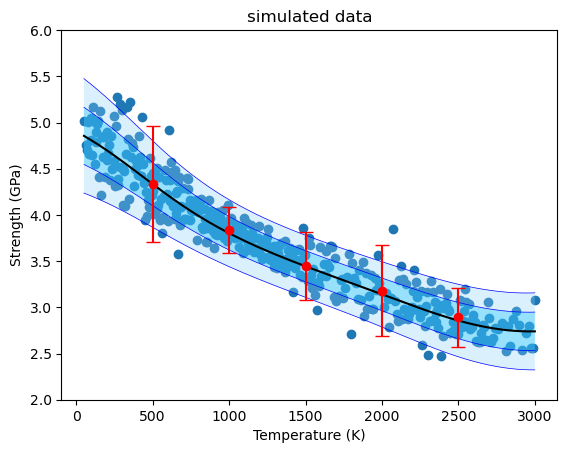

In [7]:
x_pred=np.linspace(50,3000,5000).reshape(5000,1)

x_pred_trans = poly_features.transform(x_pred)
x_pred_trans = scaler.transform(x_pred_trans)

pred_mu=model.predict(x_pred_trans)[:,0]
pred_log_sigma=model.predict(x_pred_trans)[:,1]
plt.scatter(x,y,marker='o')
plt.plot(x_pred,pred_mu,c="black")

pred_1_sd_p = pred_mu+(np.exp(pred_log_sigma))
pred_1_sd_m = pred_mu-(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu+2*(np.exp(pred_log_sigma))
pred_2_sd_m = pred_mu-2*(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.3, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.3, fc='deepskyblue', ec='None')

mu_1 = 4.3379745025188825 
sigma_1 = 0.31302466112124133*2
mu_2 = 3.8375629917234564 
sigma_2 = 0.12234167681017709*2
mu_3 = 3.450298952567952 
sigma_3 = 0.18442226260349445*2
mu_4 = 3.1780525543568867 
sigma_4 = 0.2468561120320019*2
mu_5 = 2.8908419067320454 
sigma_5 = 0.1589833777324228*2
x_values = [500, 1000, 1500, 2000, 2500]
mus = [mu_1, mu_2, mu_3, mu_4, mu_5]
sigmas = [sigma_1, sigma_2, sigma_3, sigma_4, sigma_5]

for a_x, a_mu, a_sigma in zip(x_values, mus, sigmas):
    plt.errorbar(a_x, a_mu, yerr=a_sigma, fmt='o', color='red', capsize=5)

plt.title("simulated data")
plt.ylim(2, 6)
plt.xlabel("Temperature (K)")
plt.ylabel("Strength (GPa)")
plt.show()

In [2]:
print(len(x_fit))

NameError: name 'x_fit' is not defined

In [ ]:
print(accuracy_set)

In [ ]:
print(metric_set)